# 1) Анализ 210 компаний, входящих в S&P500, с наибольшей капитализацией. Анализ динамики котировок произведен за период 2017 - 2020 год включительно. Из 210 эмитентов отобраны 9 - тех, которые за анализируемый промежуток времени обладали среднегодовой доходностью выше, чем в целом по индексу SP 500 за тот же промежуток времени - то есть выше 16.1%/год, и в то же время которые были наименее скоррелированы со всеми остальными компаниями. Наименее скоррелированные акции отбирались с целью диверсифицировать портфель. 80% портфеля имеет beta-коэффициент 0.9 - 1.2. 2 эмитента имеют beta-коэффициента 1.5 и 1.8.

# 2) Цель - на основе сформированного портфеля проверить доходность за 16 месяцев - до 29.04.2022

# 3) Список тикеров для импорта через библиотеку investpy приведен в файле SP500tickers.xlsx

In [208]:
# Импорт необходимых библиотек
import time
import investpy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf 
import warnings
warnings.filterwarnings("ignore")

In [209]:
stocks = pd.read_excel('C:/Current projects/Другое/SP500tickers.xlsx', header = None)
stocks.rename(columns={0: 'Ticker'}, inplace = True)

list_tickers = []

for i in stocks.Ticker:
    list_tickers.append(i)

# Импорт данных через библиотеку investpy

In [494]:
dfs = list()

for stock in list_tickers:
    
    df = investpy.get_stock_historical_data(stock=stock, 
                                            country='united states',
                                            from_date='01/01/2017',
                                            to_date='29/04/2022')
    
    df['Ticker'] = stock
    df.dropna(inplace=True)
    df.drop(columns = ['Currency', 'Open', 'High', 'Low'], inplace = True)
    df.dropna(inplace=True)
    
    dfs.append(df)
    time.sleep(0.7)

In [493]:
print("Количество акций для дальнейшего анализа: " + str(len(dfs)) + '\n' + 'Период ретроспективного анализа: 01/01/2017 - 29/04/2022' )

Количество акций для дальнейшего анализа: 210
Период ретроспективного анализа: 01/01/2017 - 29/04/2022


# Датафрейм с ценой закрытия всех эмитентов

In [492]:
# close_series = pd.read_excel('C:/Current projects/Другое/InvestingDF2017_2022.xlsx', index_col=None)
# close_series.index = close_series.iloc[:,0]
# close_series.drop(columns='Date', inplace = True)

In [419]:
# df for close_series
pd.set_option('display.max_columns', None)
close_series = pd.DataFrame()

for i in range(len(dfs)):
    close_series[i]=dfs[i].Close

close_series.columns = list_tickers
close_series.fillna(0, inplace = True)

#Cоздание клона дф
yields = close_series

In [357]:
writer2 = pd.ExcelWriter('C:/Current projects/Другое/InvestingDF2017_2022.xlsx') 

# write dataframe to excel 
close_series.to_excel(writer2) 

# save the excel 
writer2.save() 

print('DataFrame is successfully written to Excel File.')

DataFrame is successfully written to Excel File.


# Датафрейм с доходностью к предыдущему дню

In [420]:
yields = yields.apply(lambda x: (x.pct_change()*100).round(2))
yields.fillna(0, inplace = True)
yields.drop('2019-01-17', inplace = True)
# yields

# Cписок с теми компаниями, которые за 2017, 2020 календарный год в среднем за год показывали больше 17% доходности

In [421]:
# Cоздаём словарь с парой значений тикер - средняя годовая доходность за 2017-2020
max_yields_df = {}
for i in range(close_series.shape[1]):
    if close_series.iloc[0,i] == 0:
        continue
    elif ((close_series.iloc[-335,i] / close_series.iloc[0,i] -1) / 4).round(3) > 0.17:
        max_yields_df[close_series.columns[i]] = ((close_series.iloc[-335,i] / close_series.iloc[0,i] -1) / 4).round(3)

# Датафрейм с Close values за 01/01/2017 - 12/31/2020 только для эмитентов с доходностью, соответствующей заданному фильтру (диверсификация портфеля только для НАИМЕНЕЕ скоррелированных эмитентов)

In [422]:
close_series_after_filteringannualyields = close_series[max_yields_df.keys()]
close_series_after_filteringannualyields = close_series_after_filteringannualyields.iloc[:close_series_after_filteringannualyields.shape[0] - 587:,:]
# Удаление задублировавшихся столбцов
close_series_after_filteringannualyields = close_series_after_filteringannualyields.loc[:,~close_series_after_filteringannualyields.columns.duplicated()]

In [ ]:
# 1. Мы уже посчитали доходность и отобрали эмитентов с доходностью выше 17% годовых в течение 2017, 2018, 2019, 2020 года
# 2. Теперь за тот же промежуток времени найдем корреляцию между котировками акций отобранных эмитентов

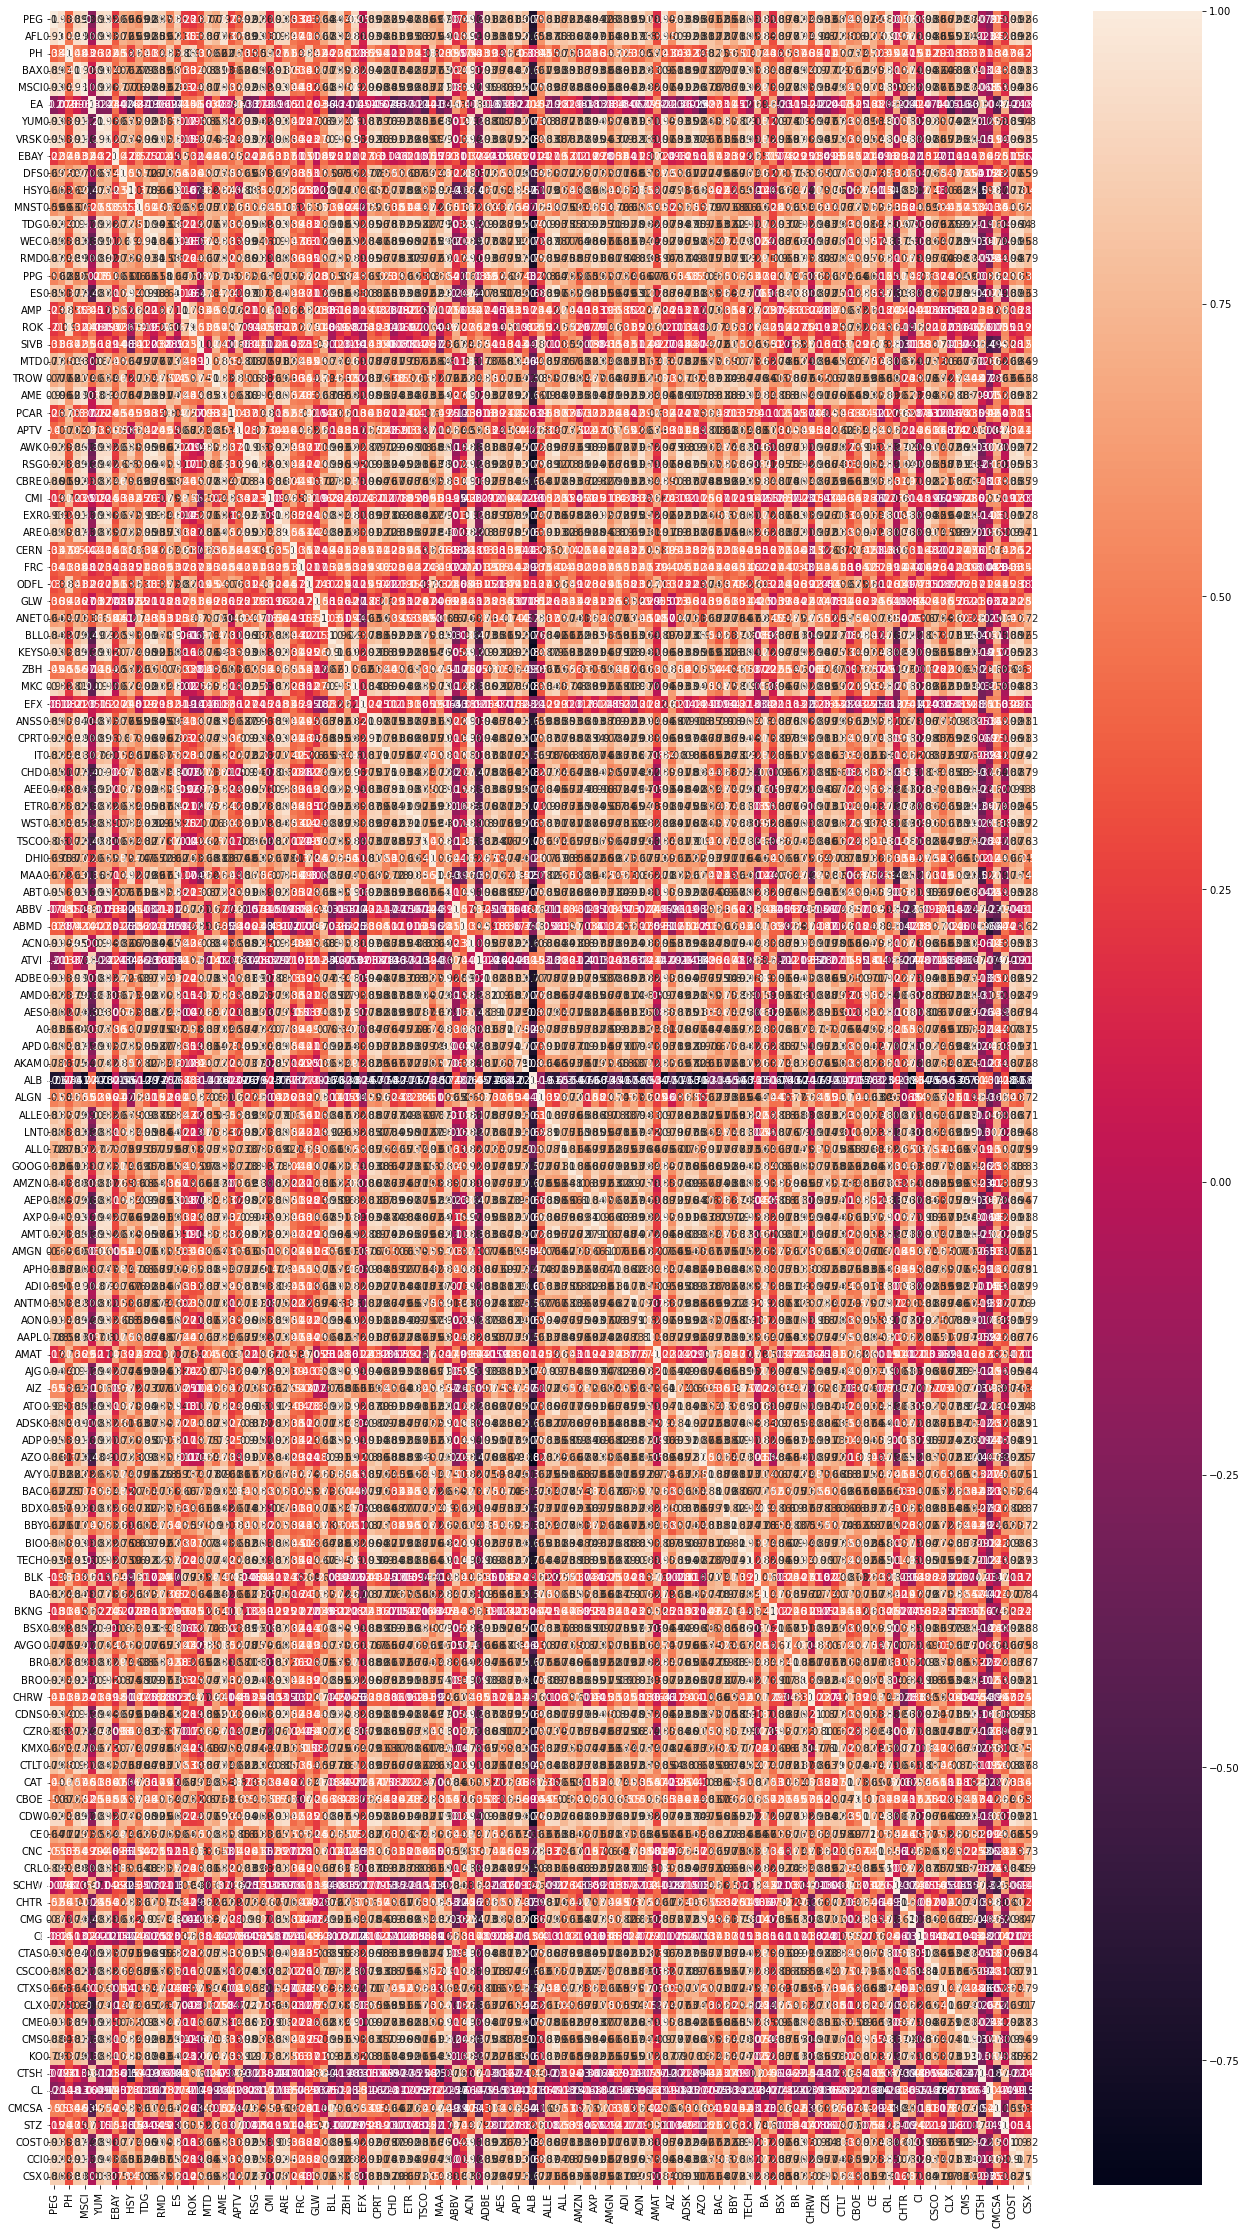

In [361]:
import seaborn as sn
import matplotlib.pyplot as plt

corr = close_series_after_filteringannualyields.corr()


from matplotlib import rcParams

rcParams['figure.figsize'] = 22,40
p = sn.heatmap(corr, annot=True)

In [432]:
corr_adjusted = list()
for i in corr:
    if corr[i][1].mean() < 0.744:
        corr_adjusted.append(i)
print('Количество эмитентов, прошедших первичный отбор на корреляцию: ' + str(len(corr_adjusted)))

Количество эмитентов, прошедших первичный отбор на корреляцию: 48


# Фильтруем словарь max_yields_df с парой значений тикер - среднегодовая доходность за 2017-2020 года, основываясь на списке отобранных эмитентов в списке corr_adjusted

In [433]:
yieldsandcorrelation_passed = {k: v for k, v in max_yields_df.items() if k in corr_adjusted}

In [ ]:
# Повторный анализ корреляции изменения котировок между оставшимися 10 эмитентами

In [434]:
secondcorrelation = close_series[yieldsandcorrelation_passed.keys()].reset_index().drop(columns='Date').iloc[:close_series_after_filteringannualyields.shape[0] - 587:,:]
secondcorr = secondcorrelation.corr()

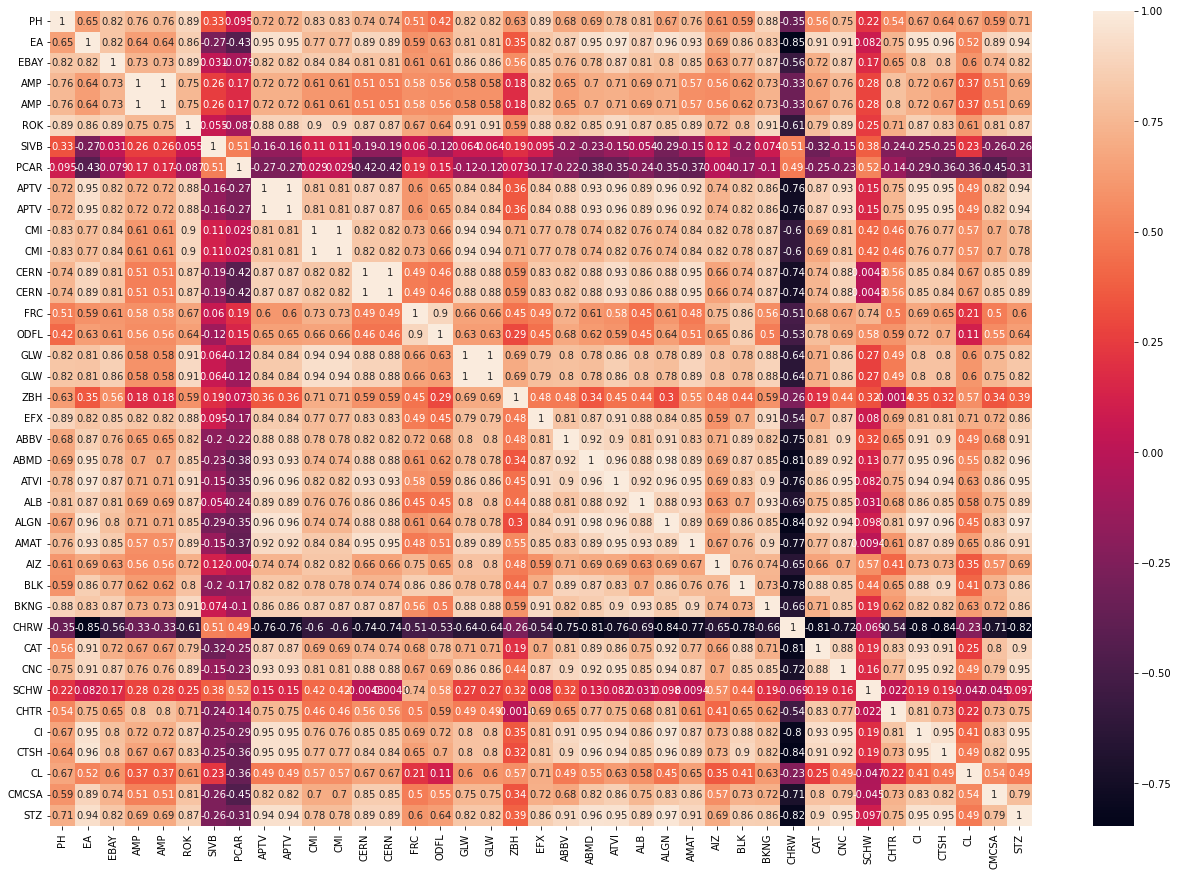

In [271]:
rcParams['figure.figsize'] = 22,15
p = sn.heatmap(secondcorr, annot=True)

In [435]:
secondcorr = secondcorr.loc[:,~secondcorr.columns.duplicated()]

In [450]:
corr_adjusted_2nd = list()

for i in range(secondcorr.shape[1]):
    if secondcorr.iloc[:,i].mean() < 0.775:
        
        corr_adjusted_2nd.append(i)
        
secondcorr.iloc[:,corr_adjusted_2nd].columns

Index(['PH', 'EBAY', 'AMP', 'SIVB', 'ODFL', 'BBY', 'BLK', 'CAT', 'CHTR'], dtype='object')

In [451]:
print('Количество эмитентов, прошедших первичный отбор на корреляцию: ' + str(len(corr_adjusted_2nd)))

Количество эмитентов, прошедших первичный отбор на корреляцию: 9


In [ ]:
# Фильтрация словаря с эмитентами после повторного отбора по признаку наименьшей скоррелированности движения котировок

In [452]:
yieldsandcorrelation_passed = {k: v for k, v in yieldsandcorrelation_passed.items() if k in secondcorr.iloc[:,corr_adjusted_2nd].columns}

# Добавляем в словарь помимо показателя доходности еще и бета-коэффициент

In [453]:
# Добавляем в словарь значения B-коэффициентов - списком после значения среднегодовой доходности

yieldsandcorrelation_passed['PH'] = [0.455, 1.57]        # Parker Hannifin Corp.
yieldsandcorrelation_passed['EBAY'] = [0.171, 1.15]      # Ebay
yieldsandcorrelation_passed['AMP'] = [0.184, 1.5]        # Ameriprise Financial Inc
yieldsandcorrelation_passed['SIVB'] = [0.184, 1.8]       # SVB Financial Group
yieldsandcorrelation_passed['ODFL'] = [0.312, 1.03]      # Old Dominion Freight Line Inc
yieldsandcorrelation_passed['AMAT'] = [0.425, 0.9]       # Applied Materials
yieldsandcorrelation_passed['BLK'] = [0.217, 1.29]       # BlackRock Inc
yieldsandcorrelation_passed['CAT'] = [0.234, 0.93]       # Caterpillar Inc
yieldsandcorrelation_passed['CHTR'] = [0.329, 1.03]      # Charter Communications Inc

yieldsandcorrelation_passed

{'PH': [0.455, 1.57],
 'EBAY': [0.171, 1.15],
 'AMP': [0.184, 1.5],
 'SIVB': [0.184, 1.8],
 'ODFL': [0.312, 1.03],
 'AMAT': [0.425, 0.9],
 'BLK': [0.217, 1.29],
 'CAT': [0.234, 0.93],
 'CHTR': [0.329, 1.03]}

In [454]:
yieldsandcorrelation_passed = pd.DataFrame(yieldsandcorrelation_passed).T
yieldsandcorrelation_passed.rename(columns={0: 'Доходность', 1: 'Бета-коэффициент'}, inplace = True)
yieldsandcorrelation_passed

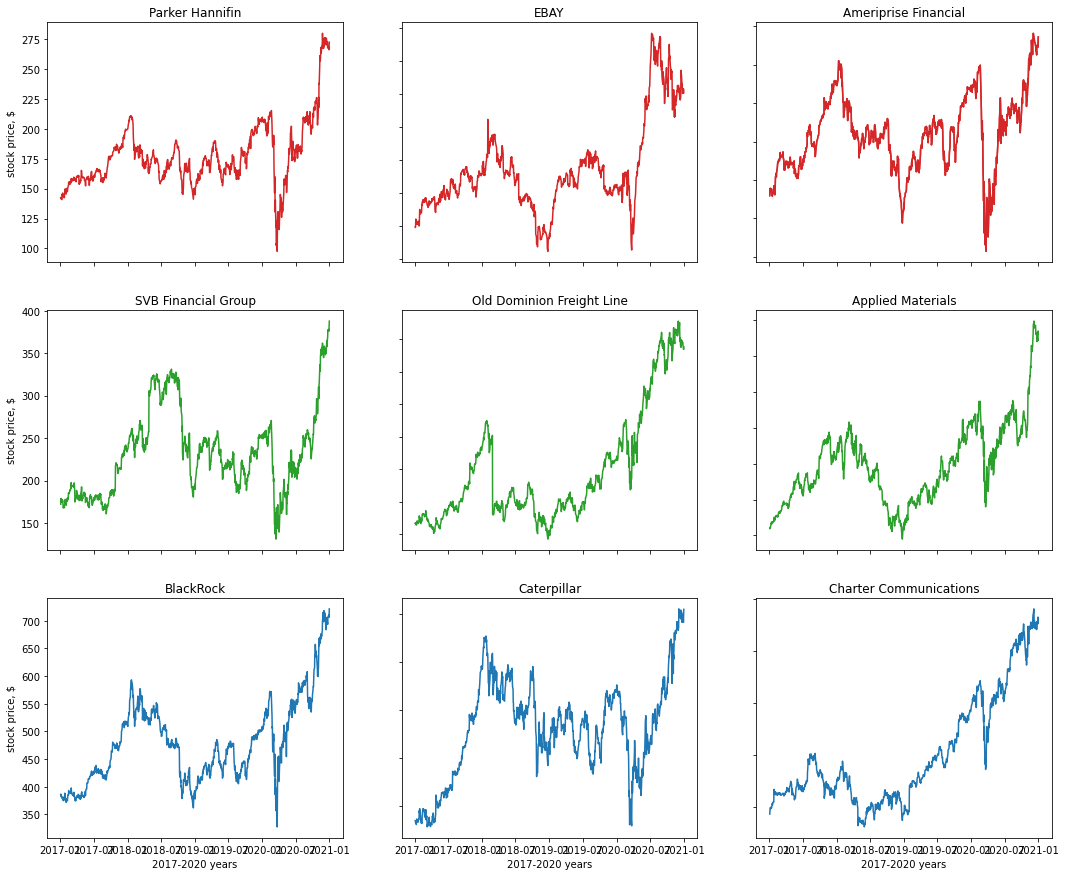

In [483]:
fig, axs = plt.subplots(3, 3)

axs[0, 0].plot(close_series.PH[:1007], 'tab:red')
axs[0, 0].set_title('Parker Hannifin')

axs[0, 1].plot(close_series.EBAY[:1007], 'tab:red')
axs[0, 1].set_title('EBAY')

axs[0, 2].plot(close_series.AMP[:1007], 'tab:red')
axs[0, 2].set_title('Ameriprise Financial')

axs[1, 0].plot(close_series.SIVB[:1007], 'tab:green')
axs[1, 0].set_title('SVB Financial Group')

axs[1, 1].plot(close_series.ODFL[:1007], 'tab:green')
axs[1, 1].set_title('Old Dominion Freight Line')

axs[1, 2].plot(close_series.AMAT[:1007], 'tab:green')
axs[1, 2].set_title('Applied Materials')

axs[2, 0].plot(close_series.BLK[:1007], 'tab:blue')
axs[2, 0].set_title('BlackRock')

axs[2, 1].plot(close_series.CAT[:1007], 'tab:blue')
axs[2, 1].set_title('Caterpillar')

axs[2, 2].plot(close_series.CHTR[:1007], 'tab:blue')
axs[2, 2].set_title('Charter Communications')

for ax in axs.flat:
    ax.set(xlabel='2017-2020 years', ylabel='stock price, $')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
rcParams['figure.figsize'] = 18,15

In [480]:
yieldsandcorrelation_passed

Доходность  Бета-коэффициент
PH         0.455              1.57
EBAY       0.171              1.15
AMP        0.184              1.50
SIVB       0.184              1.80
ODFL       0.312              1.03
AMAT       0.425              0.90
BLK        0.217              1.29
CAT        0.234              0.93
CHTR       0.329              1.03

In [ ]:

1. Все 9 эмитентов, оставшиеся после фильтрации за период 2017 - 2020 год (включительно), 
обладают среднегодовой доходностью > 17%; 
Доходность индекса S&P 500 за то же время составил 16.1%. То есть все остальные компании были исключены из анализа
либо из-за недостаточной среднегодовой доходности, либо из-за зашкаливающей скоррелированности с бумагами других эмитентов.


2. У всех этих эмитентов диапазон бета-коэффициентов находится в интервале 0.9 - 1.8. 
SVB Financial Group (1.5), Ameriprise Financials (1.8) - эмитенты, чьи бумаги обладают повышенной волатильностью 
относительно среднего показателя по рынку. То есть наиболее "рискованные" активы. Все остальные бумаги целесообразно
классифицировать либо в качестве консервативных (0.9 - 1.2 бета), либо умеренно-консервативных (1.2 - 1.5 бета).

3. Котировки акций 9 оставшихся после фильтрации эмитентов слабо скоррелированы между собой. 
Это позволяет дополнительно диверсифицировать риск потери капитала: если котировки одного из эмитентов пойдут вниз, 
это не будет означать, что весь опортфель обязательно последует вслед за ним.

4. В дополнение к пункту 3: портфель, основанный на акциях отобранных эмитентах хорошо диверсифицирован с точки зрения
отраслевой принадлежности:
    "PH" = Производитель гидравлического оборудования;
    "EBAY" = Конгломерат интернет-аукционов и интернет-магазинов;
    "SIVB" = Финансы;
    "ODFL" = Транспортная компания;
    "AMAT" = Производство и обслуживание станков для производства и эксплуатации полупроводниковой продукции;
    "BLK" = Крупнейшая международная инвестиционная компания;
    "CAT" = Один из крупнейших мировых производителей строительной и горнодобывающей техники.;
    "CHTR" = Телекоммуникационная компания и компания средств массовой информации, предоставляющая услуги под брендом Spectrum;

5. Исходя из пункта 4 можно сделать вывод, 
что сформированный портфель будет слабо подвержен колебаниям отдельно взятой отрасли.

6. Исходя из графика динамики котировок за последние 4 года (2017 - 2020 включительно), мы видим, что на анализируемом отрезке
времени котировки для всех 9 эмитентов достигают (как минимум) локального максимума. Лично для меня это является негативным
аспектом, т.к может свидетельствовать о "перегретости" бумаги. В условиях реального времени я бы либо 
не стал покупать эти бумаги вовсе, либо подождал более удобной точки входа 
(чтобы акции подешевели на 10-15% от текущих значений);


# Перейдем в эксель для расчёта оптимальных долей портфеля на основе пары риск-доходность.

In [490]:
close_series = close_series.loc[:,~close_series.columns.duplicated()]
writer = pd.ExcelWriter('C:/Current projects/Другое/output.xlsx') 

# write dataframe to excel 
yieldsandcorrelation_passed.to_excel(writer) 
close_series[yieldsandcorrelation_passed.index].to_excel(writer, 'Close-series')

# save the excel 
writer.save() 

print('DataFrame is successfully written to Excel File.')


DataFrame is successfully written to Excel File.
